In [1]:
import sys
import os

# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# Tools specific for this tutorial
# They are in the .py files accompaining this notebook 
import ba_utils               # bundle adjustment tools
import vistools               # display tools
import utils                  # IO tools
import srtm4                  # SRTM tools
import rectification          # rectification tools
import stereo                 # stereo tools
import triangulation          # triangulation tools
from vistools import printbf  # boldface print

import s2p
import pickle
import rpc_model
import rpc_utils

# Display and interface settings (just for the notebook interface)
%load_ext autoreload
%autoreload 2
%matplotlib inline
np.set_printoptions(linewidth=150)

/home/rogermm14/.local/lib/python3.6/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


### Set experiment

In [2]:
ALL_PIPELINE = True

# global variables
cam_model = 'Affine'
check_triangulation_err = False
sift_point_clouds = False
save_adj_rpcs = False
print('Global variables defined')

# select site and order of input pairs
site = 'JAX_113' # IARPA, JAX_113, JAX_161, JAX_251
order = 'heuristic' # oracle, heuristic, sift

exp_name = site+'_ba_offsets_'+order
input_dir = os.path.join('exp/',exp_name)
print('All files will be saved in "'+ input_dir + '"')
if not os.path.isdir(input_dir):
    os.mkdir(input_dir)

Global variables defined
All files will be saved in "exp/JAX_113_ba_offsets_heuristic"


### Load data (IARPA Multi-View Stereo 3D Mapping Challenge)

In [ ]:
if site == 'IARPA':   
    # list the tiff images available in the remote folder
    IARPAurl = 'http://138.231.80.166:2332/iarpa-2016/cloud_optimized_geotif/'
    myimages = utils.listFD(IARPAurl, 'TIF')

    # sort the images by acquisition date
    myimages = sorted(myimages, key=utils.acquisition_date)
    myimages.pop(11)
    myimages.pop(13)
    myimages.pop(19)
    print('Found {} images'.format(len(myimages)))

    # select the number of cameras for the current run
    n_cam = len(myimages)
    print('Number of images to be used:', n_cam)

    # load RPC coefficients
    myrpcs = [rpc_utils.rpc_from_geotiff(x) for x in myimages]
    print('Finished loading RPC coefficients')
    
    # set the coordinates of the area of interest as a GeoJSON polygon (Buenos aires AOI)
    aoi = {'coordinates': [[[-58.585185, -34.490883], [-58.585185, -34.48922 ], [-58.583104, -34.48922 ],
                                         [-58.583104, -34.490883], [-58.585185, -34.490883]]], 'type': 'Polygon'}
    aoi['center'] = np.mean(aoi['coordinates'][0][:4], axis=0).tolist() # add center field

### Load Data (2019 IEEE GRSS Data Fusion Contest)

In [3]:
import bs4
import requests

def is_absolute(url):
    return bool(requests.utils.urlparse(url).netloc)

def find(url, extension):
    """
    Recursive directory listing, like "find . -name "*extension".

    Args:
        url (str):  directory url
        extension (str): file extension to match

    Returns:
        list of urls to files
    """
    r = requests.get(url)
    soup = bs4.BeautifulSoup(r.text, 'html.parser')
    files = [node.get('href') for node in soup.find_all('a') if node.get('href').endswith(extension)]
    folders = [node.get('href') for node in soup.find_all('a') if node.get('href').endswith('/')]

    files_urls = [f if is_absolute(f) else os.path.join(url, os.path.basename(f)) for f in files]
    folders_urls = [f if is_absolute(f) else os.path.join(url, os.path.basename(f.rstrip('/'))) for f in folders]

    for u in folders_urls:
        if not u.endswith(('../', '..')):
            files_urls += find(u, extension)
    return files_urls

if site in ['JAX_113', 'JAX_161', 'JAX_251']:   
    # list the tiff images available in the remote folder
    myimages = find('http://138.231.80.166:2332/core3d/Jacksonville/WV3/PAN/', '.NTF.tif')

    # list the tiff images available in the remote folder
    mygts = find('http://138.231.80.166:2332/grss-2019/track_3/Track3-Truth-geolocated/', '_DSM.tif')
    mygt_fn = [i for i in mygts if site in i]
    aoi = utils.get_image_longlat_polygon(mygt_fn[0])
    aoi['center'] = np.mean(aoi['coordinates'][0][:4], axis=0).tolist() # add center field

    # select the number of cameras for the current run
    n_cam = len(myimages)
    print('Number of images to be used:', n_cam)

    # load RPC coefficients
    myrpcs = [rpc_utils.rpc_from_geotiff(x) for x in myimages]
    print('Finished loading RPC coefficients')

Number of images to be used: 26
Finished loading RPC coefficients


### Save image crops

Finished cropping the AOI in each image



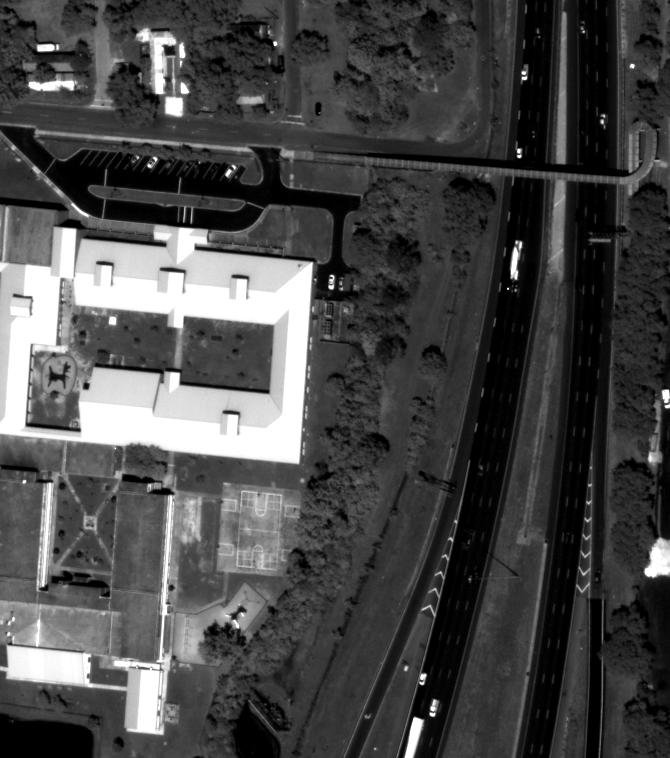
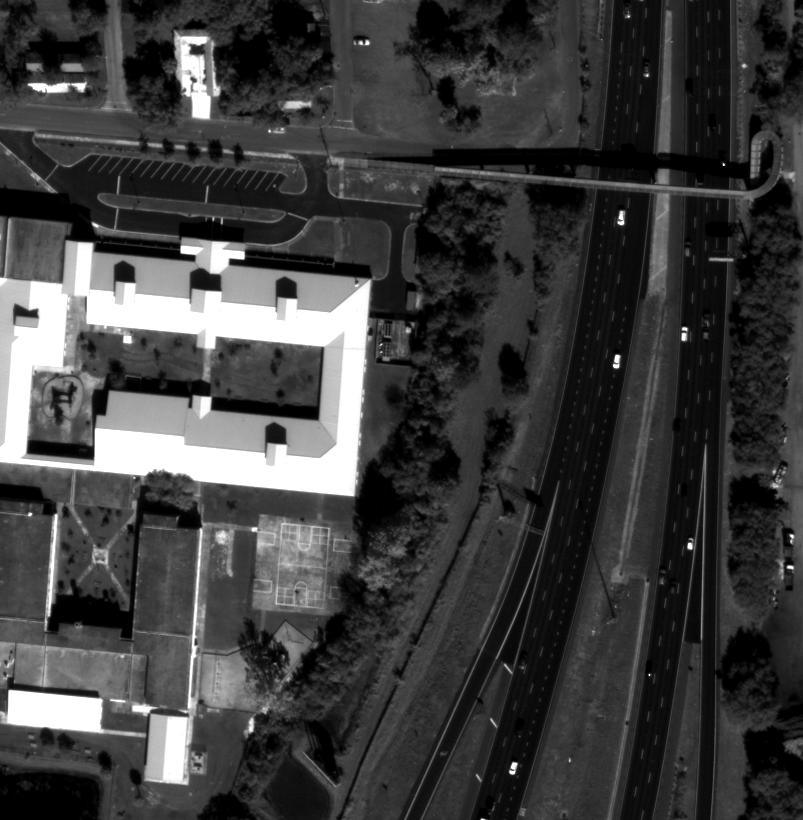
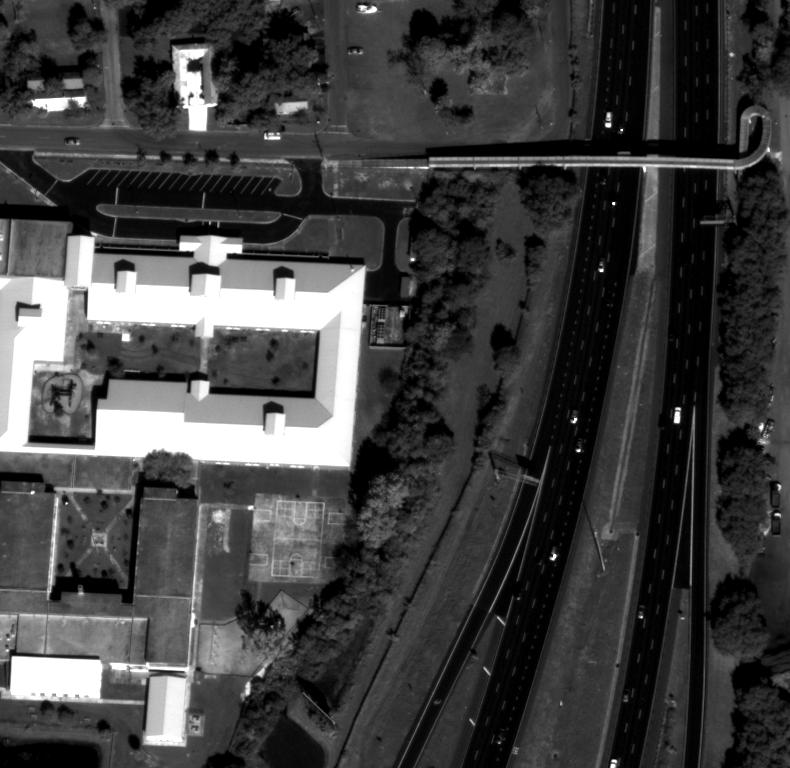
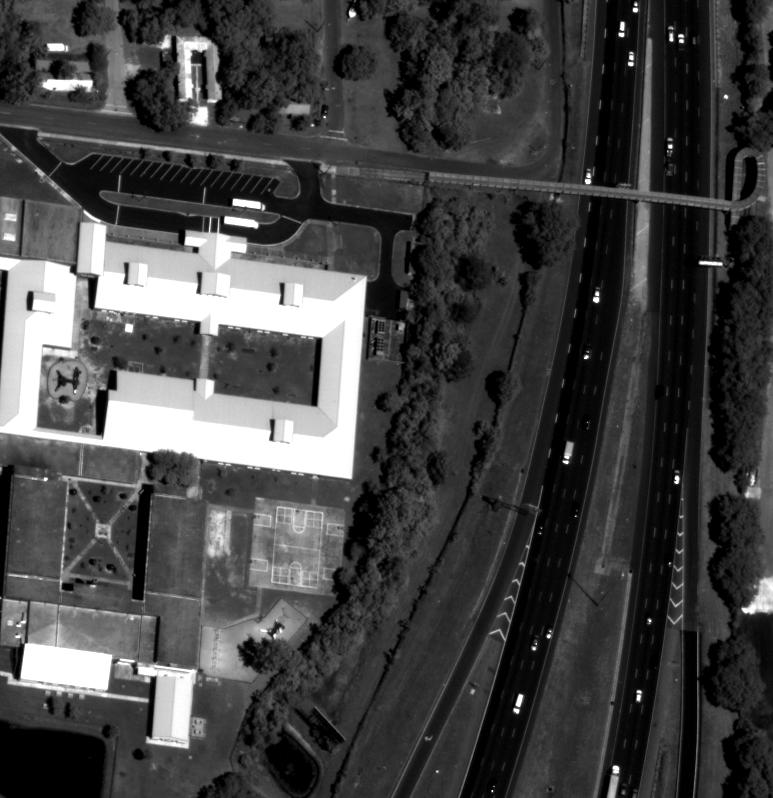
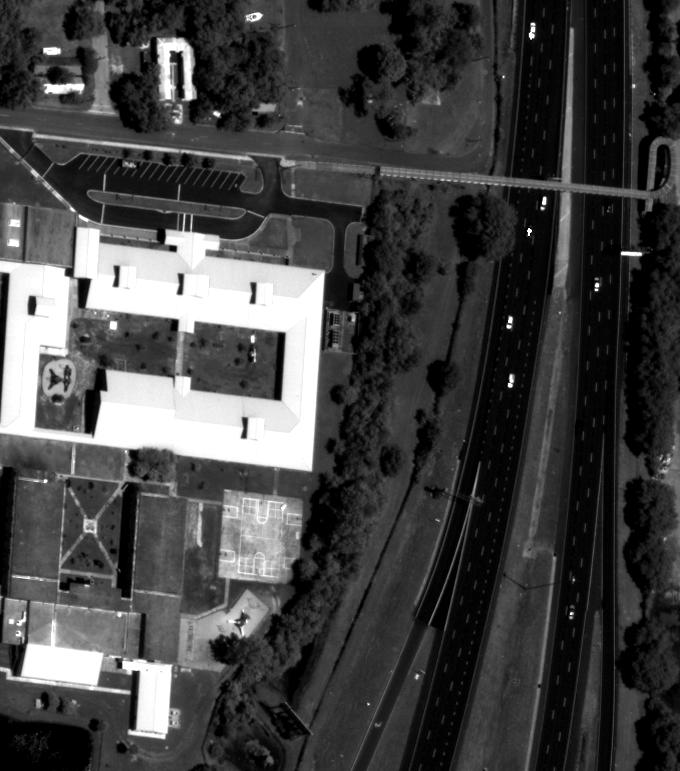
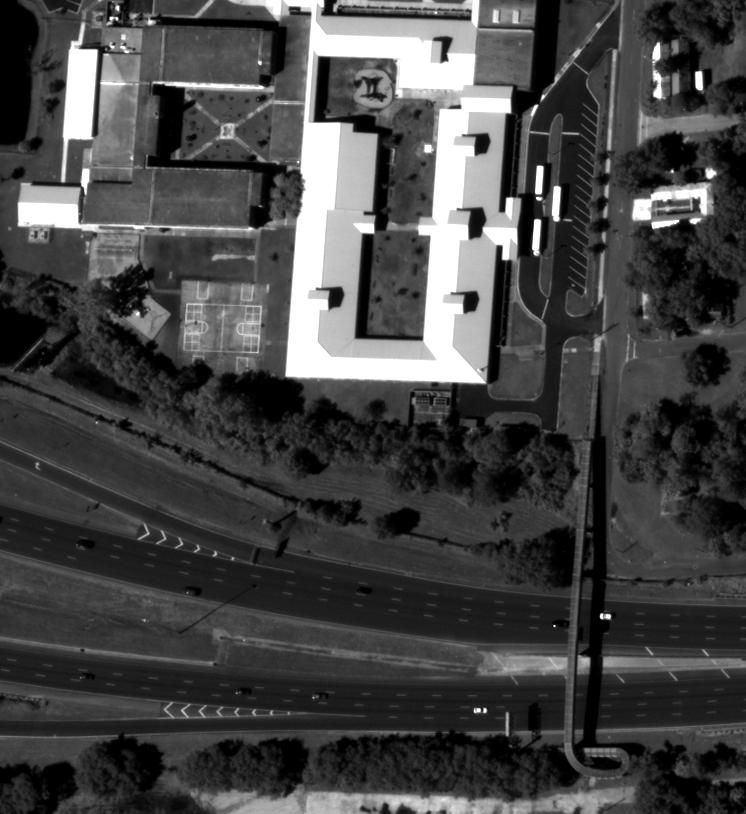
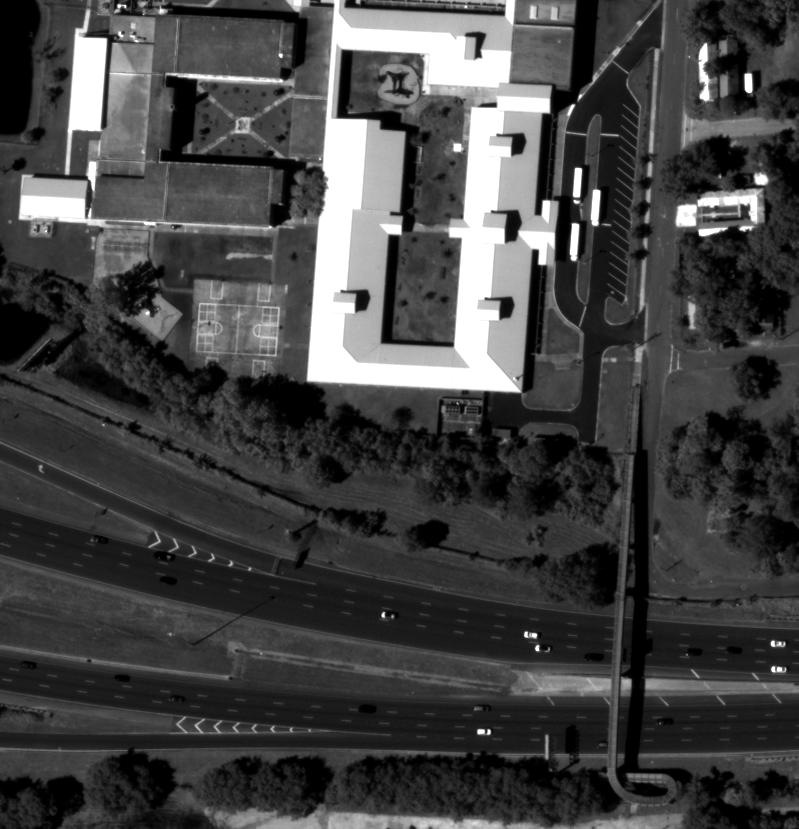
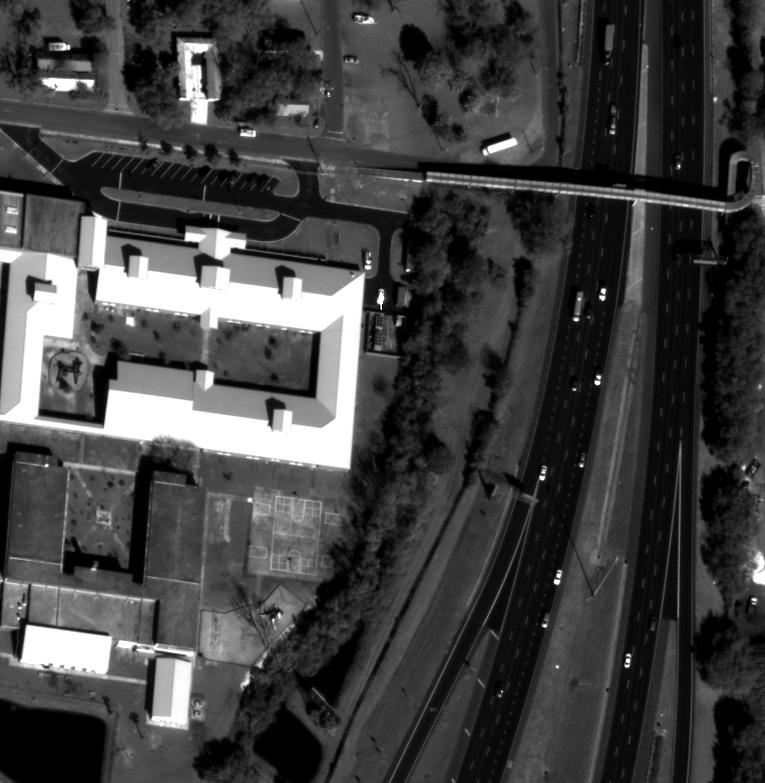
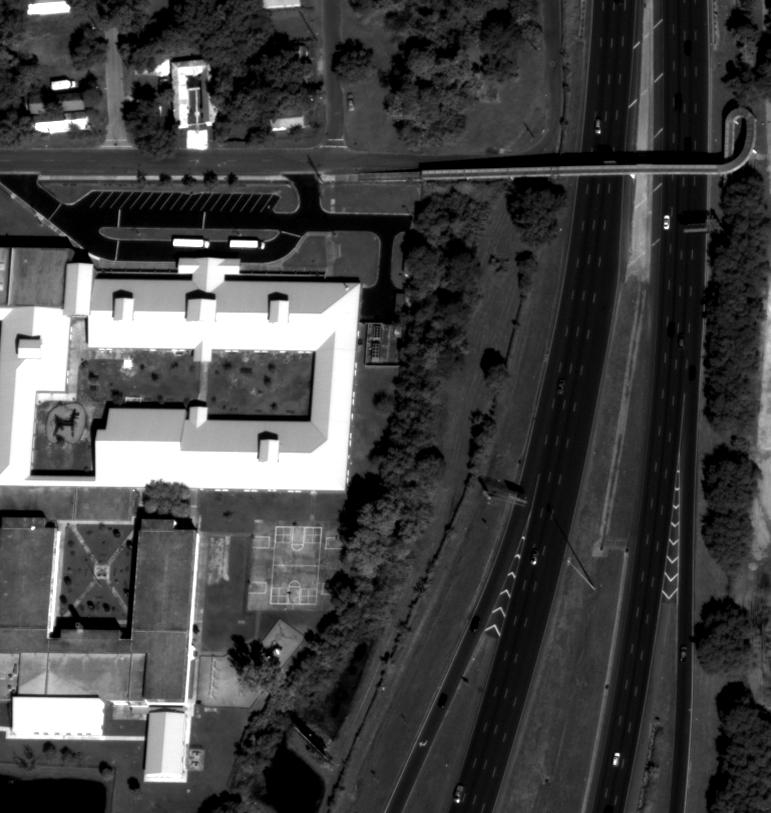
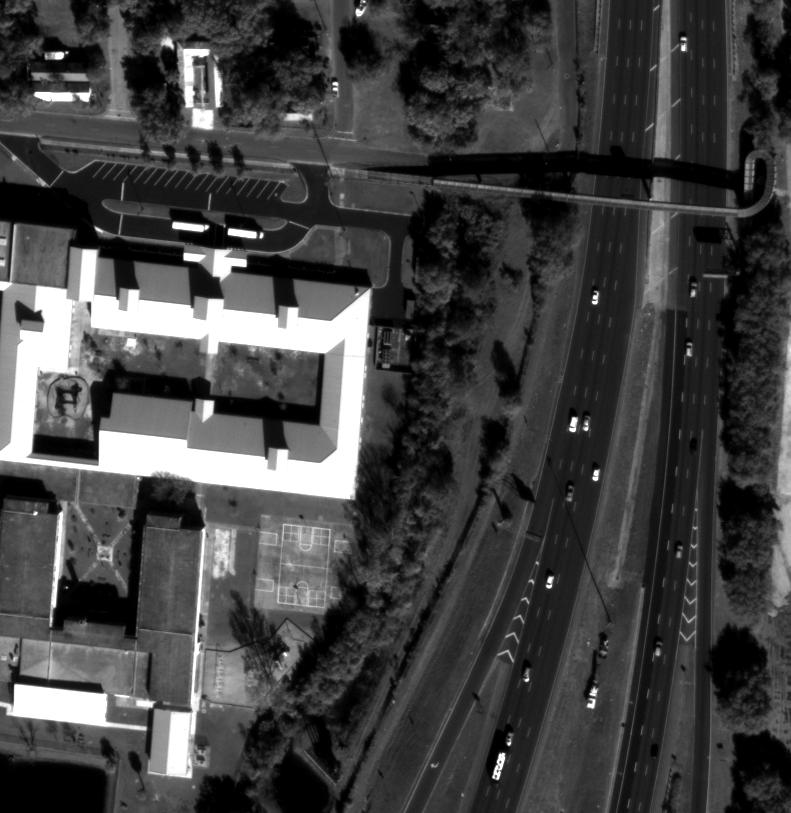
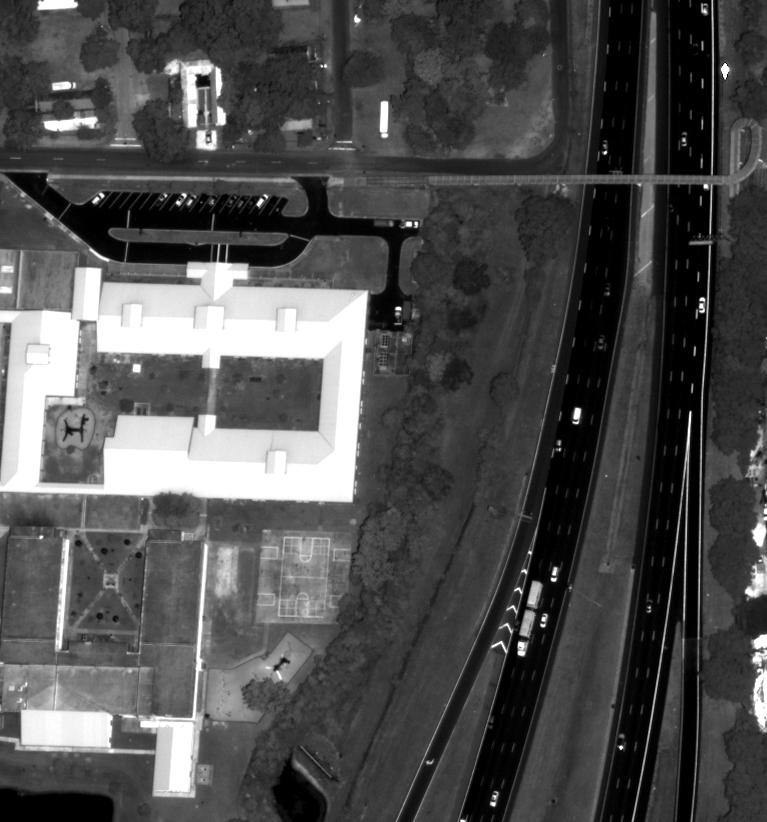
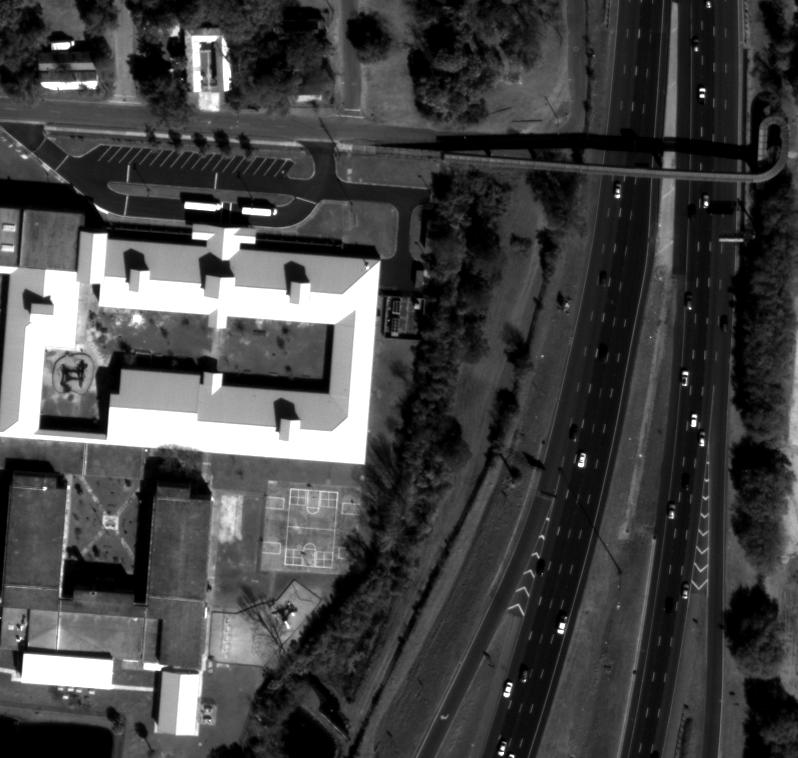
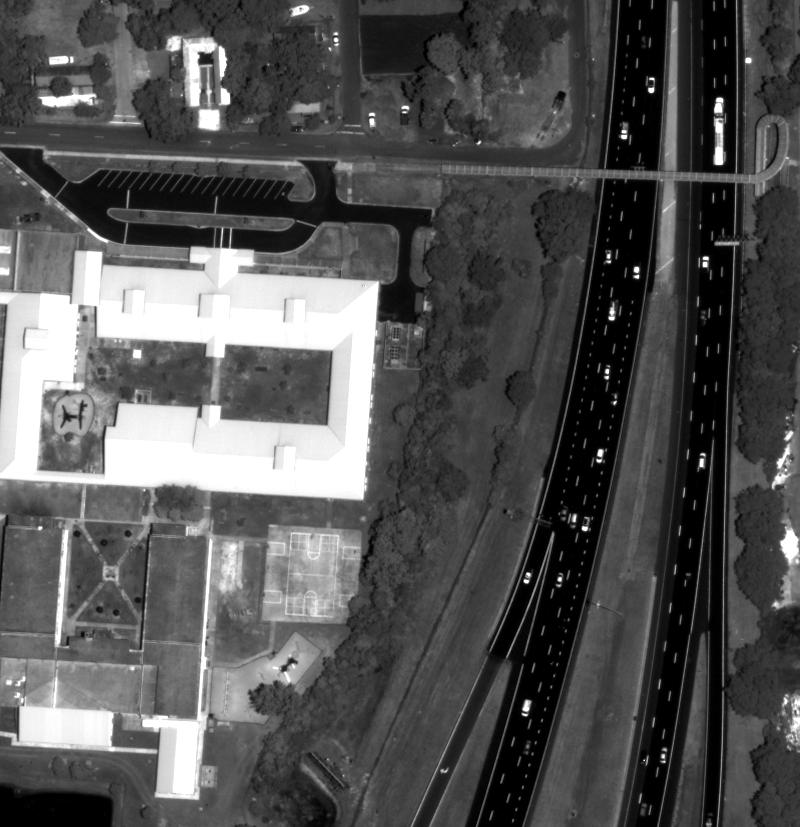
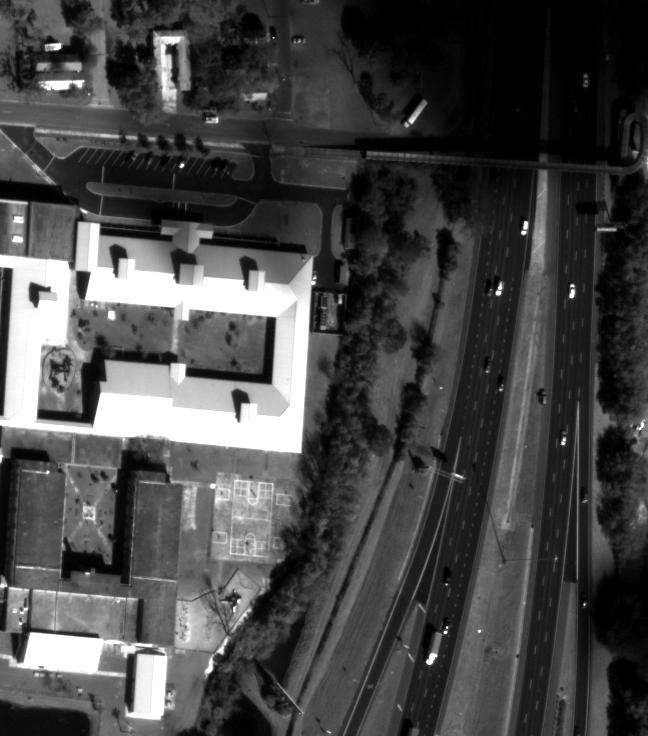
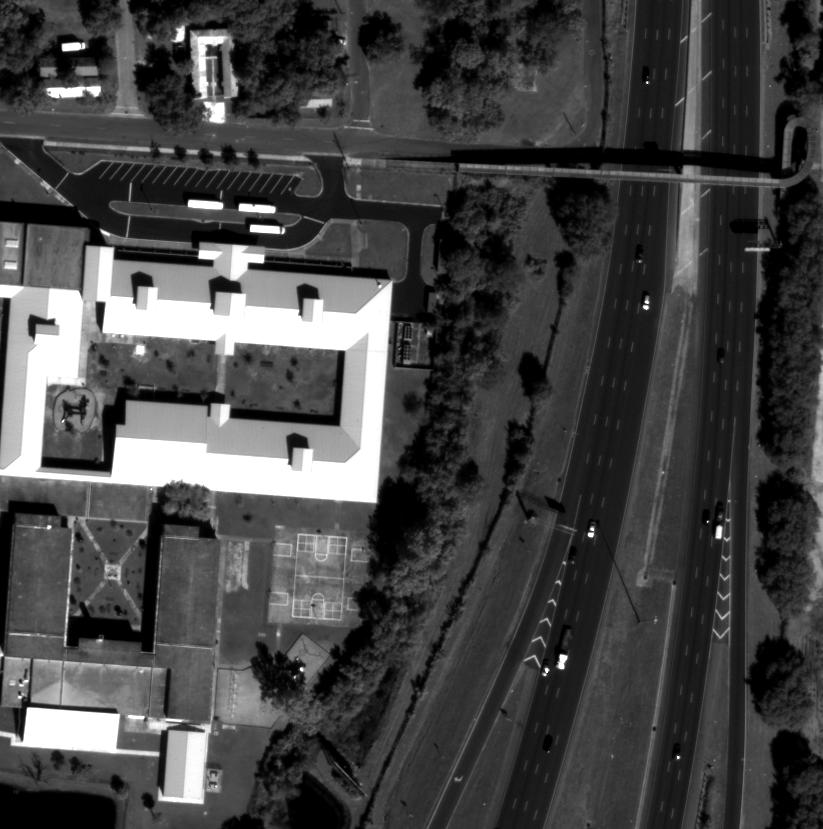
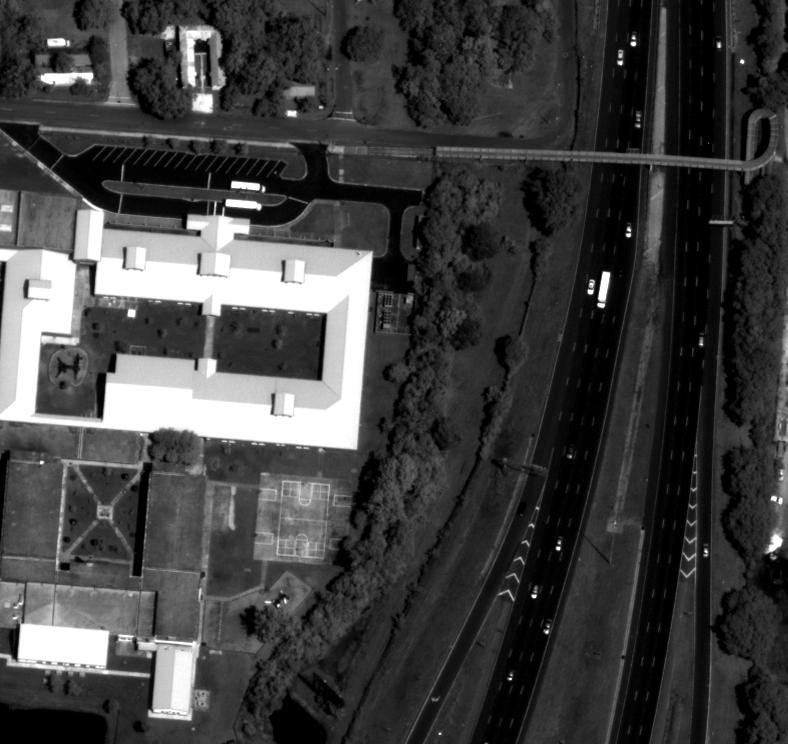
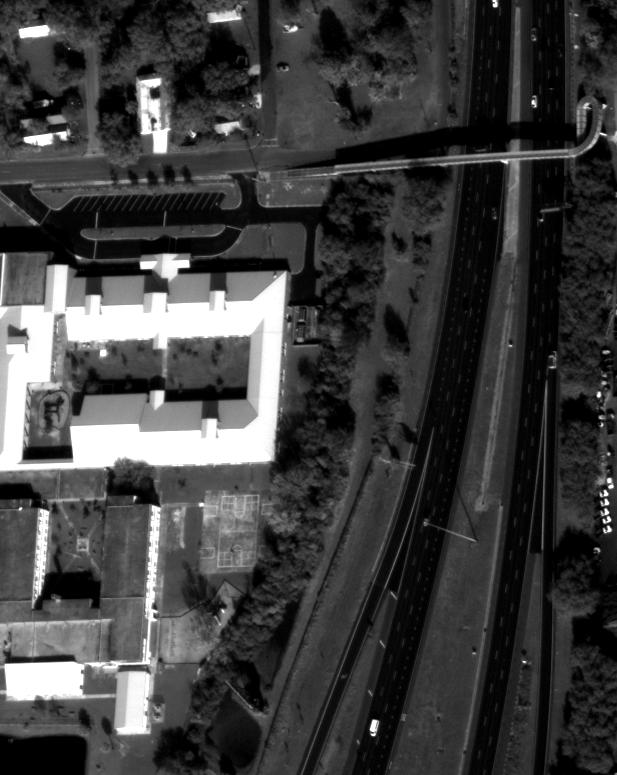
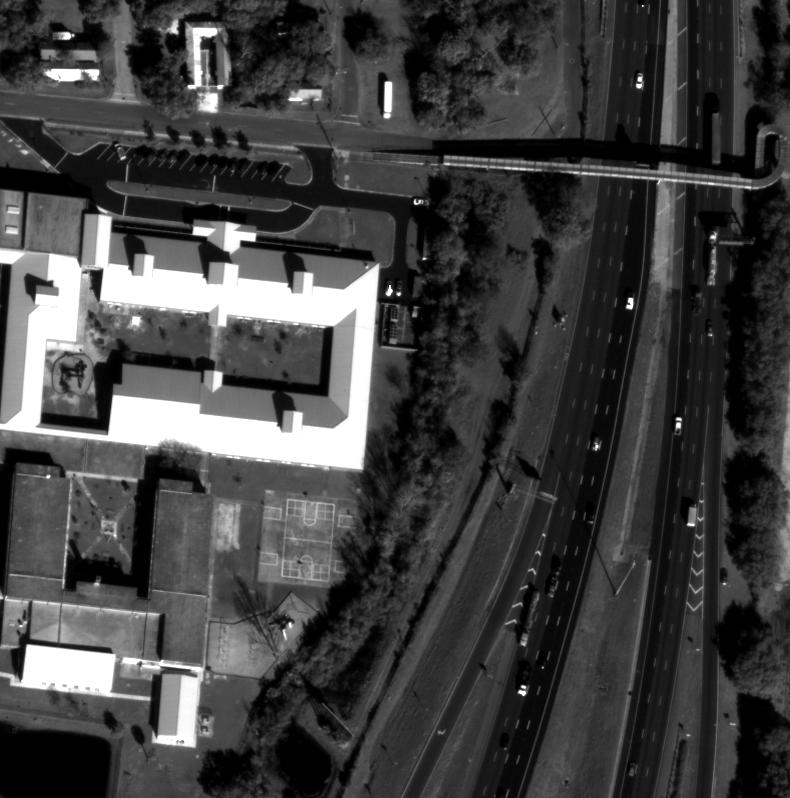
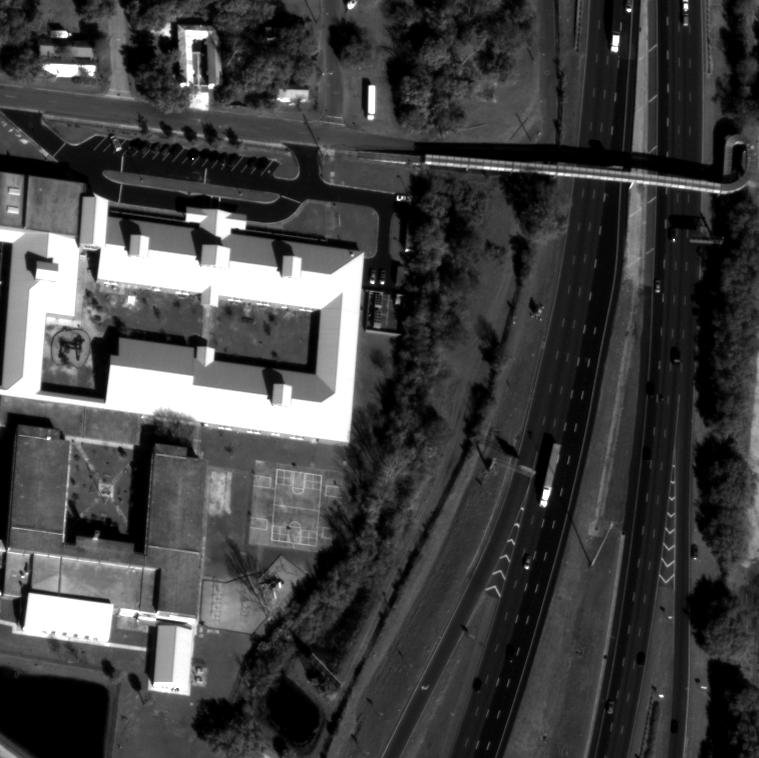
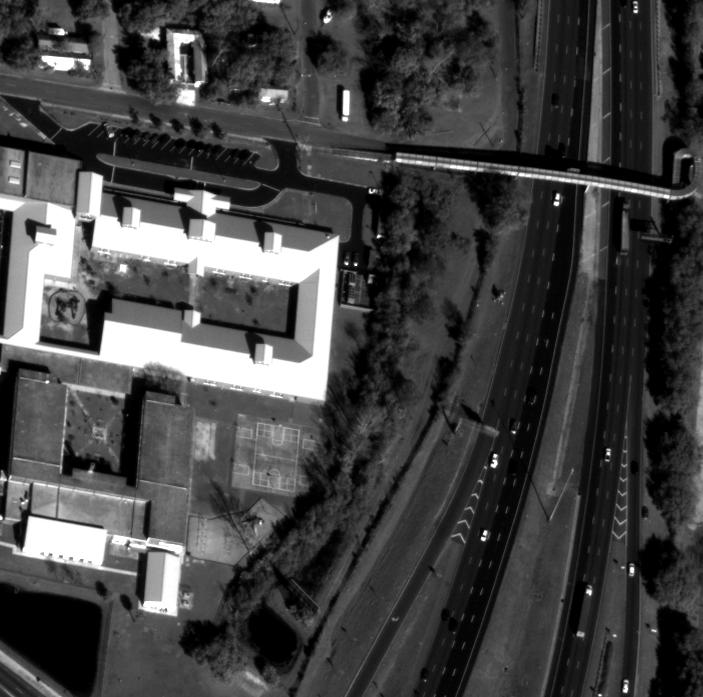
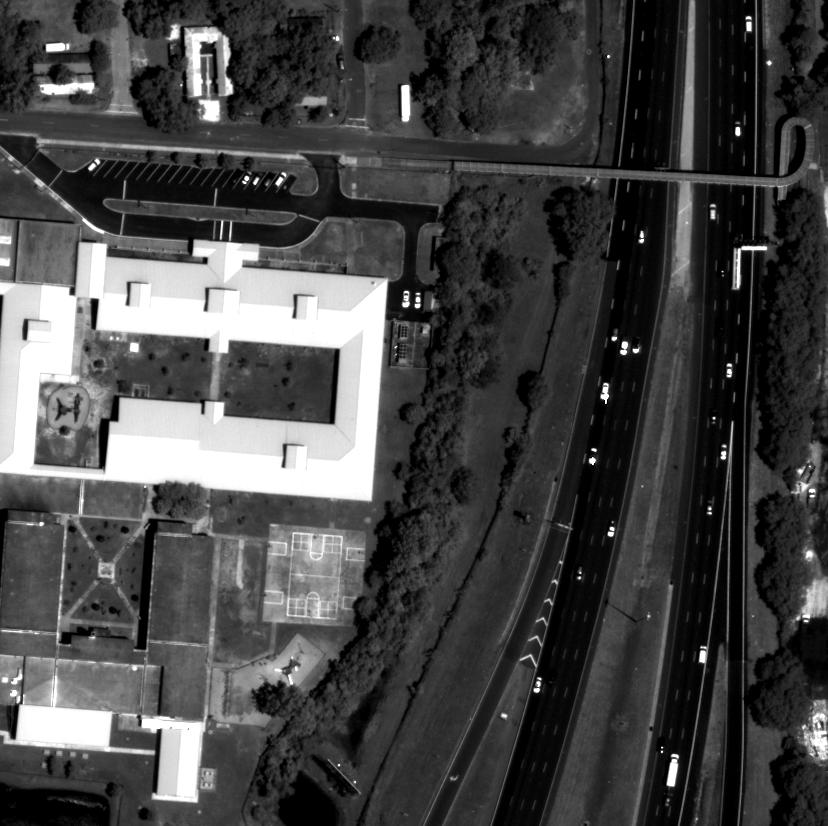
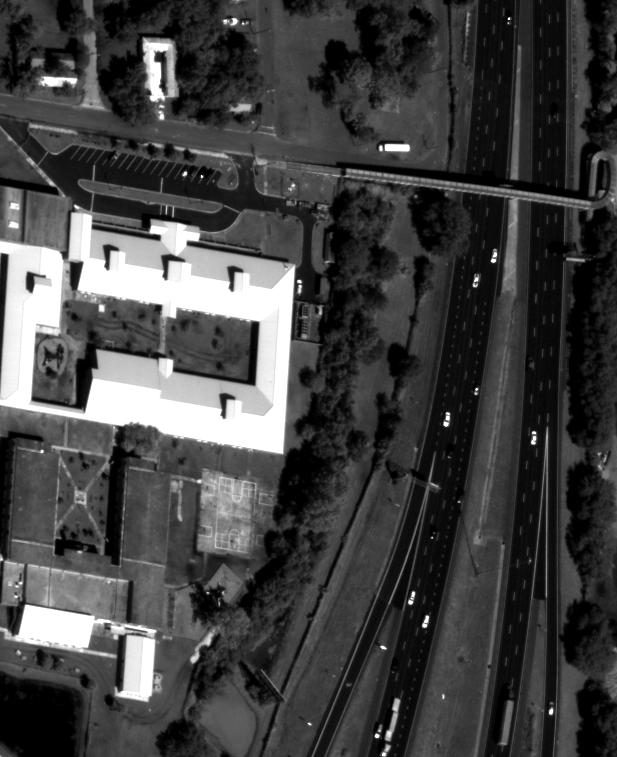
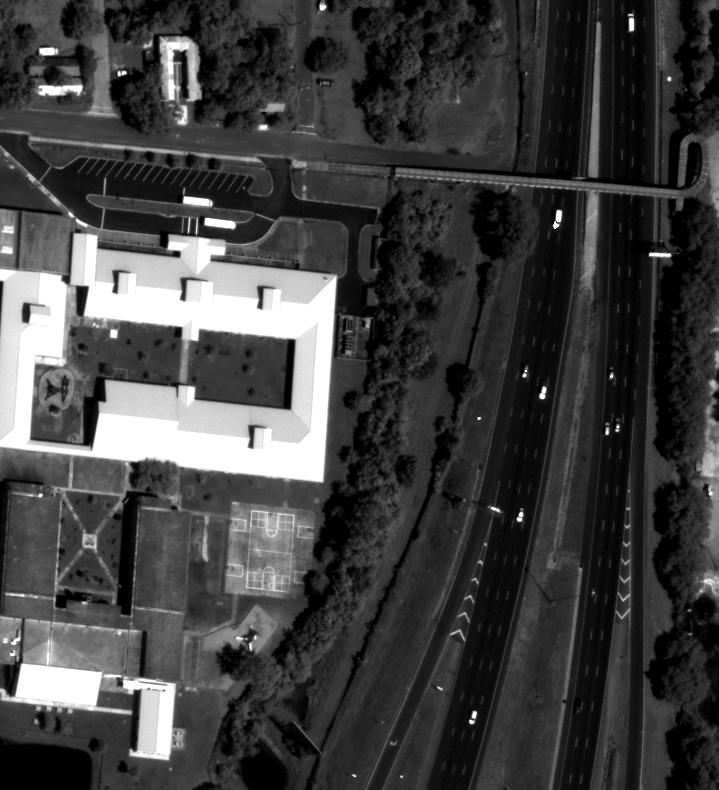
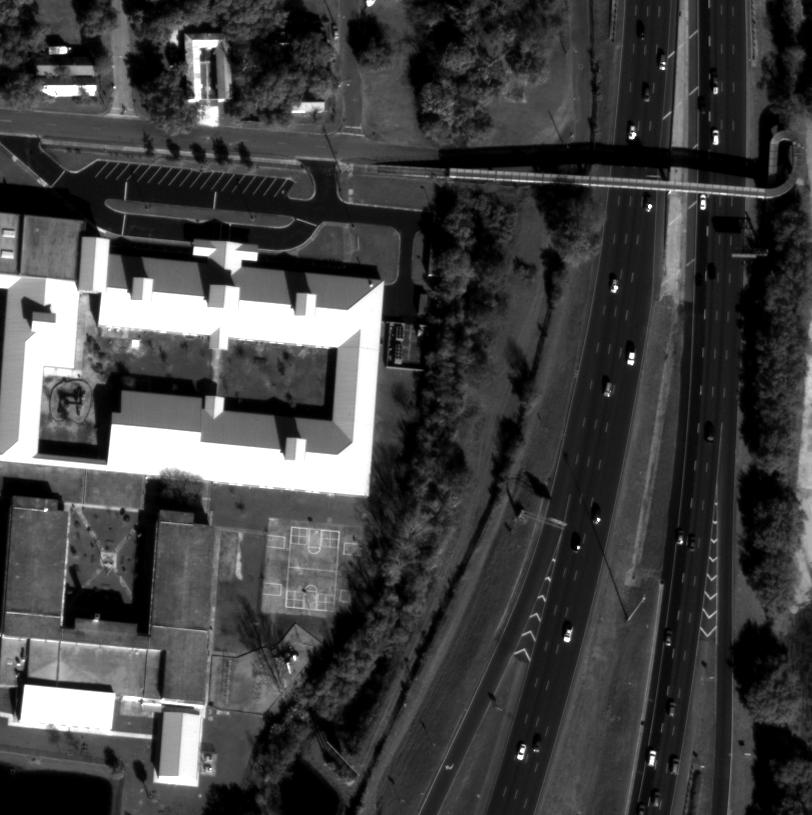
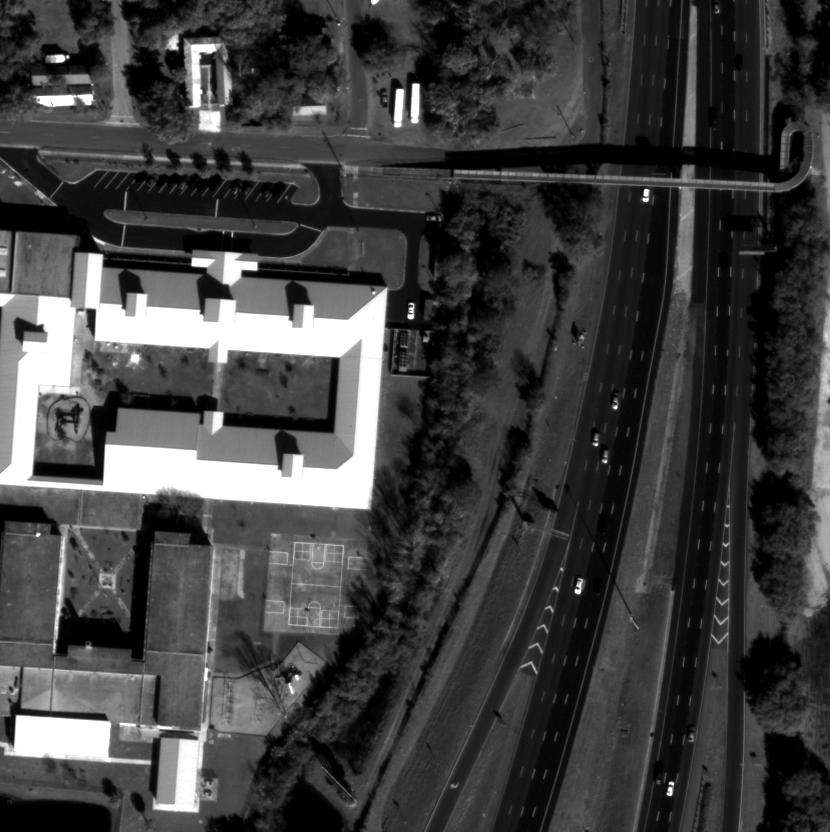
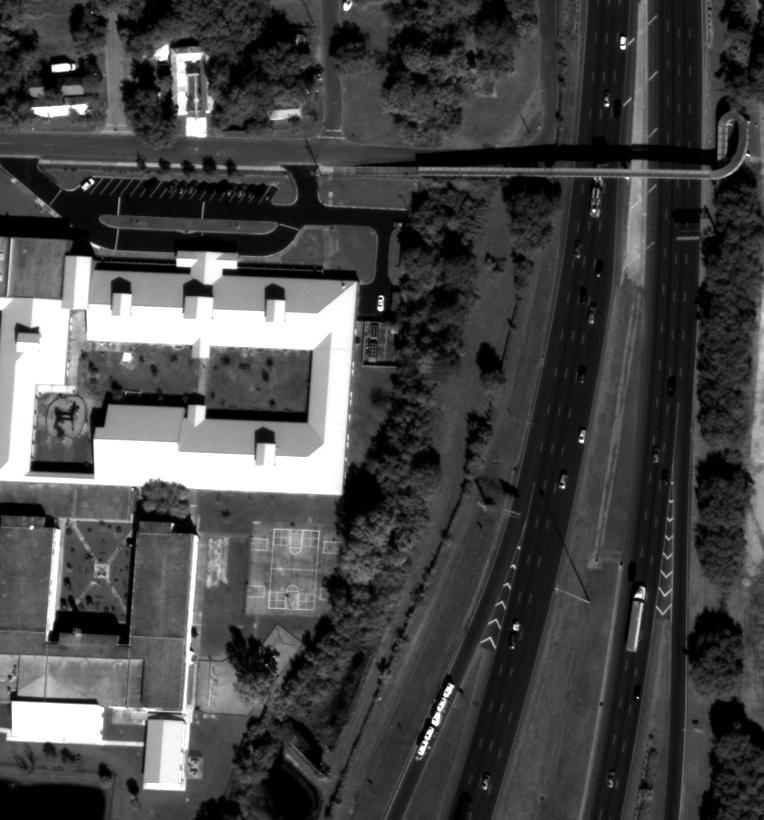

In [4]:
# get the altitude of the center of the AOI
lon, lat = aoi['center']
z = srtm4.srtm4(lon, lat)

# crop the selected AOI in each image
mycrops, im = [], []
for iter_cont, f in enumerate(range(len(myimages))):
    crop, x0, y0 = utils.crop_aoi(myimages[f], aoi, z)
    mycrops.append({ 'crop': utils.simple_equalization_8bit(crop), 'x0': x0, 'y0': y0 })
    im.append(utils.simple_equalization_8bit(crop))
    print('\r{} / {} done'.format(iter_cont+1, len(myimages)), end = '\r')
print('Finished cropping the AOI in each image')
vistools.display_gallery(im)

save_crops = False
if save_crops:
    crops_path = input_dir+'/crops'
    if not os.path.isdir(crops_path):
        os.mkdir(crops_path)
    import cv2
    for image, cont in zip(im, range(n_cam)):
        cv2.imwrite(crops_path+'/{:02}.png'.format(cont), image)

### Generate feature tracks

In [20]:
#generate input feature tracks into a correspondence matrix C with shape (2*M)xN (i.e. M cameras, N tracks)

import timeit
import cv2
from multiprocessing import Pool

input_seq = [mycrops[f]['crop'] for f in range(len(mycrops))]    
n_img = len(input_seq)

print('Running feature detection...\n')
start = timeit.default_timer()
last_stop = start

# (1) detect SIFT keypoints in all images
kp_cont = 0
features, all_keypoints, all_vertices = [], [], []
for idx in range(n_img):
    kp, des = ba_utils.find_SIFT_kp(input_seq[idx])
    kp_id = np.arange(kp_cont, kp_cont + kp.shape[0]).tolist()
    features.append({ 'kp': kp, 'des': des, 'id': kp_id })
    all_keypoints.extend(kp.tolist())
    tmp = np.vstack((np.ones(kp.shape[0]).astype(int)*idx, kp_id)).T
    all_vertices.extend( tmp.tolist() )
    print('Found', kp.shape[0], 'keypoints in image', idx)
    kp_cont += kp.shape[0]
    #im_kp=cv2.drawKeypoints(input_seq[idx],kp,outImage=np.array([]))
    #vistools.display_image(im_kp) 

stop = timeit.default_timer()
print('\n...done in {} seconds'.format(stop - last_stop))
last_stop = stop


print('\nComputing pairs to be matched...\n')

#(2) pairs to match
pairs_to_match, matching_args = [], []
for i in range(n_img):
    for j in range(i+1,n_img):
        pairs_to_match.append([i,j])
print('{} / {} pairs to be matched'.format(len(pairs_to_match),int((n_img*(n_img-1))/2)))          

stop = timeit.default_timer()
print('\n...done in {} seconds'.format(stop - last_stop))
last_stop = stop


print('\nMatching...\n')

# (3) match
all_pairwise_matches = []
for idx, [i,j] in enumerate(pairs_to_match):
    kp_i, des_i, kp_i_id = features[i]['kp'], features[i]['des'], np.array(features[i]['id'])
    kp_j, des_j, kp_j_id = features[j]['kp'], features[j]['des'], np.array(features[j]['id'])
    pts_i, pts_j, kp_i, kp_j, m_filt, m_all, indices_m_kp_i, indices_m_kp_j = ba_utils.match_pair(kp_i, kp_j, des_i, des_j)

    n_matches = 0 if indices_m_kp_i is None else len(indices_m_kp_i)
    print('Pair ({},{}) -> {} matches'.format(i,j,n_matches))

    # display matches for pair (i,j)
    #im_matches = cv2.drawMatches(mycrops[i]['crop'],kp_i,mycrops[j]['crop'],kp_j,m_filt,outImg=np.array([]))
    #vistools.display_imshow(utils.simple_equalization_8bit(im_matches))

    if indices_m_kp_i is not None:
        matches_i_j = np.vstack((kp_i_id[indices_m_kp_i], kp_j_id[indices_m_kp_j])).T
        all_pairwise_matches.extend(matches_i_j.tolist())
    

stop = timeit.default_timer()
print('\n...done in {} seconds'.format(stop - last_stop))
last_stop = stop

print('\nRunning union-find...')

def find(parents, feature_id):
    p = parents[feature_id]
    return feature_id if not p else find(parents, p)

def union(parents, feature_i_idx, feature_j_idx):
    p_1, p_2 = find(parents, feature_i_idx), find(parents, feature_j_idx)
    if p_1 != p_2: 
        parents[p_1] = p_2

parents = [None]*(len(all_vertices))
for feature_i_idx, feature_j_idx in all_pairwise_matches:
    #fi, fj = vertex_i_idx, vertex_j_idx
    union(parents, feature_i_idx, feature_j_idx)

# parents without None
parents = [find(parents, feature_id) for feature_id, v in enumerate(parents)]

stop = timeit.default_timer()
print('\n...done in {} seconds'.format(stop - last_stop))
last_stop = stop

print('\nBuilding correspondence matrix C...\n')

# parents = track_id
_, parents_indices, parents_counts = np.unique(parents, return_inverse=True, return_counts=True)
n_tracks = np.sum(1*(parents_counts>1))
track_parents = np.array(parents)[parents_counts[parents_indices] > 1]
_, track_idx_from_parent, _ = np.unique(track_parents, return_inverse=True, return_counts=True)

# t_idx, parent_id
track_indices = np.zeros(len(parents))
track_indices[:] = np.nan
track_indices[parents_counts[parents_indices] > 1] = track_idx_from_parent

C = np.zeros((2*n_cam, n_tracks))
C[:] = np.nan
for (feature_i_id, feature_j_id) in all_pairwise_matches:
    t_idx, t_idx2 = int(track_indices[feature_i_id]), int(track_indices[feature_j_id])
    im_id_i, im_id_j = all_vertices[feature_i_id][0], all_vertices[feature_j_id][0]
    C[(2*im_id_i):(2*im_id_i+2), t_idx] = np.array(all_keypoints[feature_i_id])
    C[(2*im_id_j):(2*im_id_j+2), t_idx] = np.array(all_keypoints[feature_j_id])

stop = timeit.default_timer()
print('\n...done in {} seconds'.format(stop - last_stop))
last_stop = stop

hours, rem = divmod(last_stop - start, 3600)
minutes, seconds = divmod(rem, 60)
print('\nTotal time: {:0>2}:{:0>2}:{:05.2f}'.format(int(hours),int(minutes),seconds))

pickle_out = open(input_dir+'/features.pickle','wb')
pickle.dump(C, pickle_out)
pickle_out.close()
print('\nCorrespondence matrix saved!')

Running feature detection...

Found 2980 keypoints in image 0
Found 2994 keypoints in image 1
Found 3240 keypoints in image 2
Found 3822 keypoints in image 3
Found 2856 keypoints in image 4
Found 3363 keypoints in image 5
Found 3428 keypoints in image 6
Found 2715 keypoints in image 7
Found 3632 keypoints in image 8
Found 3430 keypoints in image 9
Found 2399 keypoints in image 10
Found 3053 keypoints in image 11
Found 2948 keypoints in image 12
Found 2214 keypoints in image 13
Found 3464 keypoints in image 14
Found 3118 keypoints in image 15
Found 2809 keypoints in image 16
Found 3115 keypoints in image 17
Found 2986 keypoints in image 18
Found 2910 keypoints in image 19
Found 4133 keypoints in image 20
Found 2790 keypoints in image 21
Found 3195 keypoints in image 22
Found 3459 keypoints in image 23
Found 3282 keypoints in image 24
Found 3868 keypoints in image 25

...done in 4.4271659553050995 seconds

Computing pairs to be matched...

325 / 325 pairs to be matched

...done in 0.0004

Pair (15,18) -> 77 matches
Pair (15,19) -> 42 matches
Pair (15,20) -> 169 matches
Pair (15,21) -> 30 matches
Pair (15,22) -> 149 matches
Pair (15,23) -> 78 matches
Pair (15,24) -> 71 matches
Pair (15,25) -> 62 matches
Pair (16,17) -> 46 matches
Pair (16,18) -> 32 matches
Pair (16,19) -> 14 matches
Pair (16,20) -> 12 matches
Pair (16,21) -> 24 matches
Pair (16,22) -> 9 matches
Pair (16,23) -> 56 matches
Pair (16,24) -> 45 matches
Pair (16,25) -> 89 matches
Pair (17,18) -> 1332 matches
Pair (17,19) -> 651 matches
Pair (17,20) -> 47 matches
Pair (17,21) -> 29 matches
Pair (17,22) -> 42 matches
Pair (17,23) -> 726 matches
Pair (17,24) -> 552 matches
Pair (17,25) -> 130 matches
Pair (18,19) -> 1025 matches
Pair (18,20) -> 38 matches
Pair (18,21) -> 21 matches
Pair (18,22) -> 47 matches
Pair (18,23) -> 440 matches
Pair (18,24) -> 418 matches
Pair (18,25) -> 109 matches
Pair (19,20) -> 20 matches
Pair (19,21) -> 25 matches
Pair (19,22) -> 25 matches
Pair (19,23) -> 206 matches
Pair (19,24) ->

### Initialize all possible offsets per image according to each track

- Warning: This takes a lot of time
- The 3D point corresponding to each feature track is also initialized

In [ ]:
def offsets_pt_i(C, i):
    
    '''
    This function initalizes the offsets for all images with an observation of point i
    In : correspondence matrix C + index 'i' of the 3D point (i.e. feature track) to be used
    Out: 'offsets' vector of shape (2*number of cameras)x1 + 'pts_3d' list with the point associated to each track
    The offsets of those cameras without an observation of feature track i are filled with NaN
    '''
    
    # range of altitudes (extracted from the gt dsm)
    zmin, zmax = 15.0, 60.0
    
    # idx of images with an observation of feature track i
    im_ind = [k for k, q in enumerate(range(n_cam)) if not np.isnan(C[q*2,i])]
    n_obs = len(im_ind)

    # initialize offsets vector and output list of 3d points
    offsets = np.zeros(C.shape[0])
    offsets[:] = np.nan
    pts_3d = []
    
    # for each altitude z in the range of altitudes  
    min_sigma = np.inf
    for alt in np.arange(zmin,zmax,0.5):
        X_i = []
        for k in im_ind:
            # get coordinates of the projection of feature track i in current image
            col_obs, row_obs = C[k*2,i]+mycrops[k]['x0'], C[k*2+1,i]+mycrops[k]['y0']
            # backproject to the plane at height z using rpc
            lon, lat = myrpcs[k].localization(col_obs, row_obs, alt)
            # convert the coordinates of the candidate 3D point from geodetic to geocentric
            x, y, z = ba_utils.latlon_to_ecef_custom(lat, lon, alt)
            # add the 3D point to the list of candidates for track i
            X_i.append(np.hstack([x, y, z]))
        
        # compute the mean and the std of the list of candidate 3D points 
        X_i = np.array(X_i)
        Xhat_i = np.mean(X_i, axis=0)
        sigma_i = np.sqrt( np.sum(((X_i[:,0]-Xhat_i[0])**2)/n_obs) + np.sum(((X_i[:,1]-Xhat_i[1])**2)/n_obs) )
        # pick the point with the smaller std as the correct 3D point of feature track i
        if sigma_i < min_sigma:
            min_sigma = sigma_i.copy()
            pt3d = np.array([Xhat_i[0], Xhat_i[1], Xhat_i[2]])
    
    # initialize offsets as the difference between the real observations and the projection of 3D point i
    for j in im_ind:
        col_obs_i, row_obs_i = C[j*2,i]+mycrops[j]['x0'], C[j*2+1,i]+mycrops[j]['y0']
        col_prj_i, row_prj_i = myrpcs[j].projection_ecef_ad(pt3d[0], pt3d[1], pt3d[2])
        offsets[2*j  ] = col_prj_i - col_obs_i
        offsets[2*j+1] = row_prj_i - row_obs_i
   
    return offsets, pt3d

def build_offset_matrix_init_pts3d(C):
    offset_matrix = np.zeros((C.shape[0],C.shape[1]))
    offset_matrix[:] = np.nan
    pts3d = np.zeros((C.shape[1],3))
    
    # for each feature track, get its 3D point and initialize the offsets of all views with an observation
    for i in range(C.shape[1]):
        print('\rComputing offsets according to point {}/{}'.format(i, C.shape[1]), end = '\r')
        offset_matrix[:,i], pts3d[i,:] = offsets_pt_i(C, i)
        
    print('Successfully build offset matrix!')
        
    return offset_matrix, pts3d

Omatrix = np.around(Omatrix, 6)
pts3d = np.around(pts3d, 6)
if os.path.isfile(input_dir+'/ba_offsets.txt'):
    Omatrix = np.loadtxt(input_dir+'/ba_offsets.txt')
    pts3d = np.loadtxt(input_dir+'/ba_pts3d.txt')
    print('Loaded offset matrix!')
else:
    Omatrix, pts3d = build_offset_matrix_init_pts3d(C)
    np.savetxt(input_dir+'/ba_offsets.txt', Omatrix, delimiter = ' ')
    np.savetxt(input_dir+'/ba_pts3d.txt', pts3d, delimiter = ' ') 

### Use Adaptive RANSAC to select a single initial offset per image

In [13]:
def ransac_init_img_offset(Omatrix, im_ind):
    
    '''
    Given a set of possible offsets for the view with index 'im_ind', this function 
    uses Adaptive RANSAC to select a single offset with the largest support of inliers from the set
    '''
    
    import random
    best_inliers, best_offset = [], np.zeros(2)
    it, max_it = 0, np.inf
    p = 0.95     # probability that at least one of the random samples
    d_thr = 2.0   # distance threshold to accept inliers

    obs_ind = [k for k, j in enumerate(range(Omatrix.shape[1])) if not np.isnan(Omatrix[im_ind*2,j])]
    n_obs = len(obs_ind)
    #print('N obs in image {} : {}'.format(im_ind, n_obs))
    
    while it < max_it:
        # pick random sample in image 'im_ind' and initialize offset
        i = random.choice(obs_ind)                    # selected obs
        offset_i = Omatrix[(2*im_ind):(2*im_ind+2),i] # corresponding offset
        
        # compute inliers (i.e. those offsets with distance less than 2 px)
        inliers_i = []
        for m in obs_ind:
            offset_m = Omatrix[(2*im_ind):(2*im_ind+2),m]
            d = np.linalg.norm(offset_i-offset_m)
            if d < d_thr:
                inliers_i.append(m)
                
        n_inliers = len(inliers_i)                  # count number of inliers
        w = n_inliers/n_obs                         # estimate w - prob that a random point is an inlier
        max_it = np.log10(1-p)/np.log10(1-w +1e-16) # update number of iterations
        
        # test if this is the best model so far (if it is the case, save current offset)
        if n_inliers > len(best_inliers):
            best_inliers = inliers_i.copy()
            best_offset = offset_i.copy()
        
        it += 1
    
    print('Best offset was voted by {}% of observations'.format(len(best_inliers)/n_obs * 100))
    return best_offset

offsets = np.zeros((n_cam,2))
for j in range(n_cam):
    print('\rComputing offset for image {} ...'.format(j), end = '\r')
    offsets[j,:] = ransac_init_img_offset(Omatrix, j)

Best offset was voted by 7.391304347826087% of observations
Best offset was voted by 32.05317577548006% of observations
Best offset was voted by 32.589285714285715% of observations
Best offset was voted by 14.30084745762712% of observations
Best offset was voted by 16.359918200409% of observations
Best offset was voted by 52.52463054187192% of observations
Best offset was voted by 49.06432748538012% of observations
Best offset was voted by 12.680115273775217% of observations
Best offset was voted by 16.551724137931036% of observations
Best offset was voted by 14.959568733153638% of observations
Best offset was voted by 21.129326047358834% of observations
Best offset was voted by 5.974025974025974% of observations
Best offset was voted by 21.36279926335175% of observations
Best offset was voted by 22.277227722772277% of observations
Best offset was voted by 5.458089668615984% of observations
Best offset was voted by 21.13564668769716% of observations
Best offset was voted by 3.543307086

In [ ]:
#check that the projection after applying the slected offset is closer to the real observation

# pick random feature track i
i = np.random.randint(0,C.shape[1])
# images with an observation of track i
im_ind = [k for k, q in enumerate(range(n_cam)) if not np.isnan(C[q*2,i])]

original_reprj_e, offset_reprj_e = 0.0, 0.0
for j in im_ind:
    print('Image {}:\n'.format(j))
    
    col_obs, row_obs = C[j*2,i]+mycrops[j]['x0'], C[j*2+1,i]+mycrops[j]['y0']
    print('- original keypoint coordinates ({}.{})'.format(row_obs, col_obs))
    col_prj, row_prj = myrpcs[j].projection_ecef_ad(pts3d[i,0], pts3d[i,1], pts3d[i,2])
    print('- projection using original rpc ({}.{})'.format(np.around(row_prj,6), np.around(col_prj,6)))
    col_prj_o, row_prj_o = col_prj - offsets[j,0], row_prj - offsets[j,1]
    print('- projection using init. offset ({}.{})\n'.format(np.around(row_prj_o,6), np.around(col_prj_o,6)))
    
    original_reprj_e += np.sqrt( (col_obs - col_prj)**2 + (row_obs - row_prj)**2 )
    offset_reprj_e += np.sqrt( (col_obs - col_prj_o)**2 + (row_obs - row_prj_o)**2 )
    
print('Original reprojection error     : {}'.format(original_reprj_e))
print('Init. offset reprojection error : {}'.format(offset_reprj_e))

### Define Bundle Adjustment parameters

In [ ]:
# define camera_ind, points_ind, points_2d as needed in bundle adjustment
n_pts = pts3d.shape[0]
point_ind, camera_ind, points_2d = [], [], []
for i in range(n_pts):
    im_ind = [k for k, j in enumerate(range(n_cam)) if not np.isnan(C[j*2,i])]
    for j in im_ind:
        point_ind.append(i)
        camera_ind.append(j)
        col_obs, row_obs = C[j*2,i]+mycrops[j]['x0'], C[j*2+1,i]+mycrops[j]['y0']
        points_2d.append(np.array([col_obs, row_obs]))
pts_ind, cam_ind, pts_2d, pts_3d = np.array(point_ind), np.array(camera_ind), np.vstack(points_2d), pts3d

print('BA parameters defined.')

### Run Bundle Adjustment (soft L1 loss)

In [ ]:
import time
from scipy.optimize import least_squares, minimize
from scipy.sparse import lil_matrix

def fun(params, cam_ind, pts_ind, pts_2d, n_cam, n_pts, myrpcs):
    
    # get 3d points
    pts_3d_ba = params[n_cam * 2:].reshape((n_pts, 3))
    x, y, z = pts_3d_ba[:,0], pts_3d_ba[:,1], pts_3d_ba[:,2]

    # get offsets
    cam_params_opt = params[:n_cam * 2].reshape((n_cam, 2))
    
    # project 3d points using the current camera params
    points_proj = []
    for (p_ind, c_ind) in zip(pts_ind, cam_ind):
        col_prj, row_prj = myrpcs[c_ind].projection_ecef_ad(x[p_ind], y[p_ind], z[p_ind])
        col_prj, row_prj = col_prj - cam_params_opt[c_ind,0], row_prj - cam_params_opt[c_ind,1]
        points_proj.append(np.array([col_prj, row_prj]))
    points_proj = np.array(points_proj)
    
    # compute reprojection errors
    err = (points_proj - pts_2d).ravel()
    return err

def bundle_adjustment_sparsity(cam_ind, pts_ind, n_cam, n_pts):
    n_params = 2
    m = cam_ind.size * 2
    n = n_cam * n_params + n_pts * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(cam_ind.size)
    for s in range(n_params):
        A[2 * i, cam_ind * n_params + s] = 1
        A[2 * i + 1, cam_ind * n_params + s] = 1
        
    for s in range(3):
        A[2 * i, n_cam * n_params + pts_ind * 3 + s] = 1
        A[2 * i + 1, n_cam * n_params + pts_ind * 3 + s] = 1
            
    return A


# run BA
x0 = np.hstack((offsets.ravel(), pts_3d.ravel()))

# compute loss value and plot residuals at the initial parameters
f0 = fun(x0, cam_ind, pts_ind, pts_2d, n_cam, n_pts, myrpcs)
plt.plot(f0)

# define jacobian
A = bundle_adjustment_sparsity(cam_ind, pts_ind, n_cam, n_pts)

# run bundle adjustment
t0 = time.time()
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac',
                    ftol=1e-4, method='trf', loss='soft_l1', f_scale = 5.0,
                    args=(cam_ind, pts_ind, pts_2d, n_cam, n_pts, myrpcs))

t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba = res.x[n_cam * 2:].reshape((n_pts, 3))
offsets_ba = res.x[:n_cam * 2].reshape((n_cam, 2))

### Check reprojection error before and after Bundle Adjustment

In [5]:
# check BA error performance
init_e = np.sort(np.add.reduceat(abs(f0), np.arange(0, len(f0), 2)))
init_e_mean = np.mean(init_e)
init_e_median = np.median(init_e)

ba_e = np.sort(np.add.reduceat(abs(res.fun), np.arange(0, len(res.fun), 2)))
ba_e_mean = np.mean(ba_e)
ba_e_median = np.median(ba_e)

print('Error before BA (mean / median): {:.2f} / {:.2f}'.format(init_e_mean, init_e_median))
print('Error after  BA (mean / median): {:.2f} / {:.2f}'.format(ba_e_mean, ba_e_median))

_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(init_e, bins=40); 
f[1].hist(ba_e, bins=40); 

NameError: name 'f0' is not defined

In [24]:
if os.path.isfile(input_dir+'/ba_offsets_2.txt'):
    pickle_in = open(input_dir+'/features_after_outlier_removal.pickle','rb')
    Cnew = pickle.load(pickle_in)
    Omatrix_new = np.loadtxt(input_dir+'/ba_offsets_2.txt')
    pts3d_new = np.loadtxt(input_dir+'/ba_pts3d_2.txt')
    print('Loaded offset matrix!')
else:
    # remove outlier observations according to the reprojection error after BA
    ba_output_err = np.add.reduceat(abs(res.fun), np.arange(0, len(res.fun), 2))
    Cnew = ba_utils.remove_outlier_obs_after_ba(ba_output_err, pts_ind, cam_ind, C, outlier_thr=4.0)
    Omatrix_new, pts3d_new = build_offset_matrix_init_pts3d(Cnew)
    pickle_out = open(input_dir+'/features_after_outlier_removal.pickle','wb')
    pickle.dump(newC, pickle_out)
    pickle_out.close()
    np.savetxt(input_dir+'/ba_offsets_2.txt', np.around(Omatrix_new, 6), delimiter = ' ')
    np.savetxt(input_dir+'/ba_pts3d_2.txt', np.around(pts3d_new, 6), delimiter = ' ') 

Loaded offset matrix!


In [25]:
offsets_new = np.zeros((n_cam,2))
for j in range(n_cam):
    print('\rComputing offset for image {} ...'.format(j), end = '\r')
    offsets_new[j,:] = ransac_init_img_offset(Omatrix_new, j)
    
# define camera_ind, points_ind, points_2d as needed in bundle adjustment
n_pts = pts3d_new.shape[0]
point_ind, camera_ind, points_2d = [], [], []
for i in range(n_pts):
    im_ind = [k for k, j in enumerate(range(n_cam)) if not np.isnan(Cnew[j*2,i])]
    for j in im_ind:
        point_ind.append(i)
        camera_ind.append(j)
        col_obs, row_obs = Cnew[j*2,i]+mycrops[j]['x0'], Cnew[j*2+1,i]+mycrops[j]['y0']
        points_2d.append(np.array([col_obs, row_obs]))
pts_ind, cam_ind, pts_2d, pts_3d = np.array(point_ind), np.array(camera_ind), np.vstack(points_2d), pts3d_new

print('BA parameters defined.')

Best offset was voted by 8.695652173913043% of observations
Best offset was voted by 31.166912850812405% of observations
Best offset was voted by 32.73809523809524% of observations
Best offset was voted by 14.194915254237289% of observations
Best offset was voted by 16.359918200409% of observations
Best offset was voted by 52.58620689655172% of observations
Best offset was voted by 49.41520467836257% of observations
Best offset was voted by 12.680115273775217% of observations
Best offset was voted by 16.32183908045977% of observations
Best offset was voted by 14.420485175202154% of observations
Best offset was voted by 21.129326047358834% of observations
Best offset was voted by 6.233766233766234% of observations
Best offset was voted by 21.36279926335175% of observations
Best offset was voted by 22.277227722772277% of observations
Best offset was voted by 5.16569200779727% of observations
Best offset was voted by 21.293375394321767% of observations
Best offset was voted by 4.724409448

### Run Bundle Adjustment (L2 loss)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.6294e+06                                    1.94e+04    
       1              2         1.4623e+03      4.63e+06       1.00e+03       1.17e+00    
       2              3         1.4623e+03      2.46e-03       1.05e-01       3.44e-02    
Both `ftol` and `xtol` termination conditions are satisfied.
Function evaluations 3, initial cost 4.6294e+06, final cost 1.4623e+03, first-order optimality 3.44e-02.
Optimization took 30 seconds


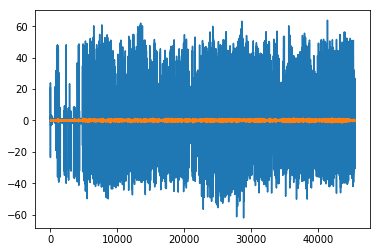

In [26]:
import time
from scipy.optimize import least_squares, minimize
from scipy.sparse import lil_matrix

def fun(params, cam_ind, pts_ind, pts_2d, n_cam, n_pts, myrpcs):
    
    # get 3d points
    pts_3d_ba = params[n_cam * 2:].reshape((n_pts, 3))
    x, y, z = pts_3d_ba[:,0], pts_3d_ba[:,1], pts_3d_ba[:,2]

    # get offsets
    cam_params_opt = params[:n_cam * 2].reshape((n_cam, 2))
    
    # project 3d points using the current camera params
    points_proj = []
    for (p_ind, c_ind) in zip(pts_ind, cam_ind):
        col_prj, row_prj = myrpcs[c_ind].projection_ecef_ad(x[p_ind], y[p_ind], z[p_ind])
        col_prj, row_prj = col_prj - cam_params_opt[c_ind,0], row_prj - cam_params_opt[c_ind,1]
        points_proj.append(np.array([col_prj, row_prj]))
    points_proj = np.array(points_proj)
    
    # compute reprojection errors
    err = (points_proj - pts_2d).ravel()
    return err

def bundle_adjustment_sparsity(cam_ind, pts_ind, n_cam, n_pts):
    n_params = 2
    m = cam_ind.size * 2
    n = n_cam * n_params + n_pts * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(cam_ind.size)
    for s in range(n_params):
        A[2 * i, cam_ind * n_params + s] = 1
        A[2 * i + 1, cam_ind * n_params + s] = 1
        
    for s in range(3):
        A[2 * i, n_cam * n_params + pts_ind * 3 + s] = 1
        A[2 * i + 1, n_cam * n_params + pts_ind * 3 + s] = 1
            
    return A


# run BA
x0 = np.hstack((offsets.ravel(), pts_3d.ravel()))

# compute loss value and plot residuals at the initial parameters
f0 = fun(x0, cam_ind, pts_ind, pts_2d, n_cam, n_pts, myrpcs)
plt.plot(f0)

# define jacobian
A = bundle_adjustment_sparsity(cam_ind, pts_ind, n_cam, n_pts)

# run bundle adjustment
t0 = time.time()
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac',
                    ftol=1e-4, method='trf', #loss='soft_l1', f_scale = 5.0,
                    args=(cam_ind, pts_ind, pts_2d, n_cam, n_pts, myrpcs))

t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba = res.x[n_cam * 2:].reshape((n_pts, 3))
offsets_ba = res.x[:n_cam * 2].reshape((n_cam, 2))

Error before BA (mean / median): 19.64 / 17.50
Error after  BA (mean / median): 0.33 / 0.24


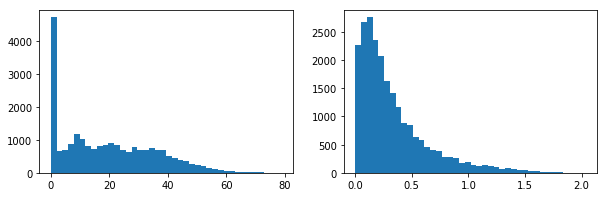

In [27]:
# check BA error performance
init_e = np.sort(np.add.reduceat(abs(f0), np.arange(0, len(f0), 2)))
init_e_mean = np.mean(init_e)
init_e_median = np.median(init_e)

ba_e = np.sort(np.add.reduceat(abs(res.fun), np.arange(0, len(res.fun), 2)))
ba_e_mean = np.mean(ba_e)
ba_e_median = np.median(ba_e)

print('Error before BA (mean / median): {:.2f} / {:.2f}'.format(init_e_mean, init_e_median))
print('Error after  BA (mean / median): {:.2f} / {:.2f}'.format(ba_e_mean, ba_e_median))

_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(init_e, bins=40); 
f[1].hist(ba_e, bins=40); 

In [28]:
'''

#check that the projection after applying the correction offset is closer to the real observation

# pick random feature track i
i = np.random.randint(0,C.shape[1])
# images with an observation of track i
im_ind = [k for k, q in enumerate(range(n_cam)) if not np.isnan(C[q*2,i])]

original_reprj_e, offset_reprj_e, offset_reprj_e2 = 0.0, 0.0, 0.0
for j in im_ind:
    print('Image {}:\n'.format(j))
    
    col_obs, row_obs = C[j*2,i]+mycrops[j]['x0'], C[j*2+1,i]+mycrops[j]['y0']
    print('- original keypoint coordinates ({}.{})'.format(row_obs, col_obs))
    col_prj, row_prj = myrpcs[j].projection_ecef_ad(pts3d[i,0], pts3d[i,1], pts3d[i,2])
    print('- projection using original rpc ({}.{})'.format(np.around(row_prj,6), np.around(col_prj,6)))
    col_prj_o, row_prj_o = col_prj - offsets[j,0], row_prj - offsets[j,1]
    print('- projection using init. offset ({}.{})\n'.format(np.around(row_prj_o,6), np.around(col_prj_o,6)))
    col_prj_o2, row_prj_o2 = col_prj - offsets_ba[j,0], row_prj - offsets_ba[j,1]
    print('- projection using init. offset ({}.{})\n'.format(np.around(row_prj_o2,6), np.around(col_prj_o2,6)))
    
    original_reprj_e += np.sqrt( (col_obs - col_prj)**2 + (row_obs - row_prj)**2 )
    offset_reprj_e += np.sqrt( (col_obs - col_prj_o)**2 + (row_obs - row_prj_o)**2 )
    offset_reprj_e2 += np.sqrt( (col_obs - col_prj_o2)**2 + (row_obs - row_prj_o2)**2 )
    
print('Original reprojection error     : {}'.format(original_reprj_e))
print('Init. offset reprojection error : {}'.format(offset_reprj_e))
print('Final offset reprojection error : {}'.format(offset_reprj_e2))

'''

Image 1:

- original keypoint coordinates (9110.524841308594.12540.263862609863)
- projection using original rpc (9135.226002.12568.600256)
- projection using init. offset (9105.21417.12574.23654)

- projection using init. offset (9113.06857.12578.502644)

Image 9:

- original keypoint coordinates (9360.05029296875.12552.458084106445)
- projection using original rpc (9382.617004.12572.97755)
- projection using init. offset (9362.895101.12590.831144)

- projection using init. offset (9363.728149.12589.693944)

Original reprojection error     : 68.09210331026095
Init. offset reprojection error : 72.8636249193557
Final offset reprojection error : 75.74034884374362


### Compute point clouds for all pairs

In [ ]:
if ALL_PIPELINE:
    
    # approximate RPCs as affine cameras
    cam_model = 'Affine'
    P_crop = []
    p_geodetic = [aoi_buenos_aires['center'][0], aoi_buenos_aires['center'][1], 31.0] # lon, lat, alt
    p_x, p_y, p_z = ba_utils.latlon_to_ecef_custom(p_geodetic[1], p_geodetic[0], p_geodetic[2]) # in meters
    p_geocentric = [p_x, p_y, p_z]
    for rpc, crop, j in zip(myrpcs, mycrops, np.arange(n_cam)):
        # approximate current rpc as an affine 3x4 matrix
        P_img = rectification.rpc_affine_approximation3(rpc, p_geocentric, offsets_ba_new[j,:])
        x, y, w, h = utils.bounding_box_of_projected_aoi(rpc, aoi_buenos_aires, rpc.alt_offset)
        #express P in terms of crop coord by applying the translation x0, y0 (i.e. top-left corner of the crop)
        T_crop = np.array([[1., 0., -crop['x0']], [0., 1., -crop['y0']], [0., 0., 1.]])
        current_P = T_crop @ P_img
        P_crop.append(current_P/current_P[2,3])
    print('RPCs successfully approximated as affine cameras')
    
    # build point clouds
    
    import warnings
    warnings.filterwarnings('ignore')
    
    list_of_pairs = ba_utils.get_predefined_pairs(site, order, myimages)

    if not os.path.isdir(input_dir+'/clouds'):
        os.mkdir(input_dir+'/clouds')

    for pair in list_of_pairs:
        i, j = pair
        print('Pocessing pair ({},{})...'.format(i, j))
        cloud =  ba_utils.cloud_from_pair(i, j, P_crop[i], P_crop[j], cam_model, myimages, mycrops, aoi_buenos_aires)
        x , y, z = cloud[:,0], cloud[:,1], cloud[:,2]
        lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T
        ba_utils.write_point_cloud_ply(input_dir+'/clouds/dense_cloud_{:02}_{:02}.ply'.format(i,j), xyz)
        print('Done!\n')

### Postprocess output DSMs

In [ ]:
if ALL_PIPELINE:
    
    from PIL import Image
    import re
    import subprocess

    if not os.path.isdir(input_dir+'/dsm'):
        os.mkdir(input_dir+'/dsm')
    if not os.path.isdir(input_dir+'/cdsm'):
        os.mkdir(input_dir+'/cdsm')
    if not os.path.isdir(input_dir+'/output'):
        os.mkdir(input_dir+'/output')

    # use the aoi to set the limits of the grid where the point clouds will be projected to DSMs
    emin, emax, nmin, nmax = utils.utm_bounding_box_from_lonlat_aoi(aoi)
    px_size = 0.300000011920929 # to set the DSMs resolution

    # project all point colouds to DSMs
    print('Creating DSMs...')
    ply_files = [filenames for (dirpath, dirnames, filenames) in os.walk(input_dir+'/clouds')][0]
    for iter_cont, filename in enumerate(ply_files):
        xyz = ba_utils.read_point_cloud_ply(input_dir+'/clouds/'+filename)
        dem, dem_nan, dem_std = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=px_size)
        im = Image.fromarray(dem_nan)
        im.save(input_dir+'/dsm/dsm_{}.tif'.format(os.path.splitext(filename[12:])[0]))
        print('\r{} / {} done'.format(iter_cont+1, len(ply_files)), end = '\r')
    print('\nDone!\n')

    # post-process DSMs
    print('Post-processing DSMs...')
    dsm_files = [filenames for (dirpath, dirnames, filenames) in os.walk(input_dir+'/dsm')][0]
    
    for iter_cont, filename in enumerate(dsm_files):
        dsm = input_dir+'/dsm/'+filename # original dsm

        # small hole interpolation by closing
        cdsm = input_dir+'/cdsm/c'+filename  # dsm after closing
        
        os.system('bin/morsi square closing {0} | bin/plambda {0} - "x isfinite x y isfinite y nan if if" -o {1}'.format(dsm, cdsm))

        # no interpolation is used here
        # since interpolated dsms are only used in pipelineA to comptue the max ncc transfromation
        print('\r{} / {} done'.format(iter_cont+1, len(dsm_files)), end = '\r')
    print('\nDone!\n')

### Fuse output DSMs

In [ ]:
if ALL_PIPELINE:

    from PIL import Image

    # stack the N output DSMs in a WxHxN grid
    rcdsm_files = [filenames for (dirpath, dirnames, filenames) in os.walk(input_dir+'/cdsm')][0]
    olist = [input_dir+'/cdsm/'+filename for filename in rcdsm_files]
    u=[]
    for ofile in olist:
        u.append(np.array(Image.open(ofile)))
    stacked_rcdsm = np.dstack(u)

    # pointwise median to fuse all DSMs
    fusion_result = np.nanmedian(stacked_rcdsm, axis=2)

    # visualize the number of samples per pixel
    nan_idx = np.isnan(stacked_rcdsm)
    obs_per_px = np.sum((~nan_idx).astype(int), axis=2).astype(float)

    vistools.display_imshow(obs_per_px)
    vistools.display_imshow(fusion_result)
    im = Image.fromarray(fusion_result)
    im.save(input_dir+'/output/fused_dsm.tif')

### Prepare GT DSM

In [ ]:
# prepare GT dem to obtain performance score

if ALL_PIPELINE:

    from PIL import Image

    emin, emax, nmin, nmax = utils.utm_bounding_box_from_lonlat_aoi(aoi)
    px_size = 0.300000011920929
    
    # read the ground truth geotiff 
    gt_dsm = np.array(Image.open('gt/'+site+'_gt.tif'))

    if site == 'IARPA':
        # write the necessary data from gdalinfo (northing (y) needs to be expressed in negative coordinates)
        epsg, x, y, px_size = 32721, 354449.320, 6182457.920 - 10000000, 0.300000011920929
        # attention: the top-left corner from the gt tiff and the one from the aoi are not exactly coincident
        # save the gt geotiff but this time with northing in negative coordinates
        ba_utils.save_geotiff(input_dir+'/gt_dsm2.tif', gt_dsm.astype(np.float64), epsg, x, y, r=px_size)
    else:
        os.system('cp gt/'+site+'_gt.tif '+input_dir+'/gt_dsm2.tif')

    # elevate the geotiff we just wrote and write the point cloud in a ply file
    os.system('bin/elevate '+input_dir+'/gt_dsm2.tif > '+input_dir+'/gt_cloud.txt')
    os.remove(input_dir+'/gt_dsm2.tif')
    xyz = ba_utils.read_point_cloud_txt(input_dir+'/gt_cloud.txt')
    os.remove(input_dir+'/gt_cloud.txt')
    ba_utils.write_point_cloud_ply(input_dir+'/gt_cloud.ply', xyz)

    # project the recently created point cloud into the aoi and create a dem
    xyz = ba_utils.read_point_cloud_ply(input_dir+'/gt_cloud.ply')
    dem_3,dem_nan,dem_std = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=px_size)

    # save the dem as the new ready-to-be-used gt
    im = Image.fromarray(dem_nan)
    im.save(input_dir+'/gt_dsm_nan.tif')

    # filter those values where we do not have gt available
    rows_with_gt = ~np.all(np.isnan(dem_nan), axis=1)
    cols_with_gt = ~np.all(np.isnan(dem_nan), axis=0)
    dem_3 = dem_3[rows_with_gt, :]
    dem_3 = dem_3[:, cols_with_gt]
    im = Image.fromarray(dem_3)
    im.save(input_dir+'/gt_dsm_registered.tif')

    if site == 'IARPA':
        vistools.display_imshow(dem_3, cmap='jet', range=(10,50))
    else:
        vistools.display_imshow(dem_3, cmap='jet', range=(5,-25))

### Register solution and ground-truth DSMs

In [ ]:
if ALL_PIPELINE:
    
    # prepare SOL dem to obtain performance score

    # read fused and gt dem
    out_dsm = np.array(Image.open(input_dir+'/output/fused_dsm.tif'))
    gt_dsm  = np.array(Image.open(input_dir+'/gt_dsm_nan.tif'))

    # filter those values where we do not have gt available
    rows_with_gt = ~np.all(np.isnan(gt_dsm), axis=1)
    cols_with_gt = ~np.all(np.isnan(gt_dsm), axis=0)
    out_dsm2 = out_dsm[rows_with_gt, :]
    out_dsm2 = out_dsm2[:, cols_with_gt]
    im = Image.fromarray(out_dsm2)
    im.save(input_dir+'/output/fused_dsm2.tif')

    out_dsm = input_dir+'/output/fused_dsm2.tif'
    gt_dsm  = input_dir+'/gt_dsm_registered.tif'

    # compute horizontal registration on the interpolated DSMs
    trans = input_dir+'/output/t_sol.txt'
    os.system('bin/ncc_compute_shift {} {} 5 > {}'.format(gt_dsm, out_dsm, trans))
    dx, dy = np.loadtxt(trans)[:2]

    # compute vertical registration on the original DSMs
    os.system('bin/ncc_compute_shift {} {} 5 {} {} > {}'.format(gt_dsm, out_dsm, dx, dy, trans))

    # apply the registration
    os.system('bin/ncc_apply_shift {} `cat {}` {}'.format(out_dsm, trans, input_dir+'/output/sol_dsm_registered.tif'))

    # copy geotiff properties from the gt dsm to the sol dsm
    #os.system('python gdalcopyproj.py {} {}'.format(gt_dsm, input_dir+'/sol_dsm.tif'))

    os.remove(input_dir+'/output/fused_dsm2.tif')
    sol_dsm = np.array(Image.open(input_dir+'/output/sol_dsm_registered.tif'))
    
    if site == 'IARPA':
        vistools.display_imshow(sol_dsm, cmap='jet', range=(10,50))
    else:
        vistools.display_imshow(sol_dsm, cmap='jet', range=(5,-25))

### Evaluation

In [ ]:
if ALL_PIPELINE:
    
    # compute score
    from PIL import Image

    #input_dir = 'ba_experiments/50pairs_iarpa'

    dem_gt = np.array(Image.open(input_dir+'/gt_dsm_registered.tif'))
    dem_sol = np.array(Image.open(input_dir+'/output/sol_dsm_registered.tif'))

    # compute mse and completness (i.e. % of px with error lower than 1 m)
    # first remove possible nans from the solution
    idx = ~np.isnan(dem_sol)
    dem_gt2, dem_sol2 = dem_gt[idx], dem_sol[idx]
    #total_px = dem_gt2.shape[0]
    nan_values = 100 - ((dem_gt2.shape[0]/ (dem_gt.shape[0] * dem_gt.shape[1]) ) * 100)
    mean_e = np.mean((abs(dem_gt2 - dem_sol2)))
    median_e = np.median(abs(dem_gt2 - dem_sol2))
    std_e = np.std(abs(dem_gt2 - dem_sol2))
    total_px = dem_gt.shape[0] * dem_gt.shape[1]
    completness = sum( (abs(dem_gt2 - dem_sol2) < 1.0).astype(int) ) / total_px * 100

    plt.hist(abs(dem_gt2 - dem_sol2), bins=50) 

    print('score:', completness)
    print('nan:', nan_values)
    print('mean_e:', mean_e)
    print('median_e:', median_e)
    print('std_e:', std_e)